# Encoder Decoder

## Set up

In [1]:
import os
import numpy as np
import random
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
from torch.utils.data import DataLoader

from utils.PytorchUtils import PytorchUtils
from utils.Visualisation import Visualisation

PyTorch version: 2.1.0+cu121


In [2]:
device = PytorchUtils.device_section()
print(f'Using device: {device}')

Using device: cuda


In [3]:
WIDTH, HEIGHT = 128, 128
STROKE_SIZE = 3
IMAGE_FACTOR = 1.1
EPOCHS: int = 57
BATCH_SIZE: int = 256

MODEL = "conv-variational2"
CONV_ARCHITECTURE = [1, 16, 32]
LINEAR_ARCHITECTURE = [WIDTH * HEIGHT, WIDTH * HEIGHT * 3 // 4]
DROPOUT = 0.1
BATCH_NORM = True

LR = 0.0005

RL=0.9
KL=0.1

LEN_SUBSET = 100000
VALID_TEST_SUBSET = 10000

In [4]:
CONV_MODEL_DATA = "conv" in MODEL

In [5]:
resources_folder = 'resources/sketchrnn'

classes = ['apple', 'golf club', 'hedgehog', 'moon', 'mushroom', 'rain', 'roller coaster', 'squirrel']
nb_classes = len(classes)
class_size = {}

data = []

for class_name in classes:
    data_class = np.load(os.path.join(resources_folder, 'sketchrnn_' + class_name + '.npz'), allow_pickle=True, encoding="latin1")

    data.append(data_class)
    class_size[class_name] = len(data_class)

print(class_size[classes[0]])
print(f'loaded numpy bitmaps, {nb_classes} classes')
print(len(data))
print(data[0].keys())
print(len(data[0]['train']))
print(len(data[0]['valid']))
print(len(data[0]['test']))

3
loaded numpy bitmaps, 8 classes
8
KeysView(NpzFile 'resources/sketchrnn/sketchrnn_apple.npz' with keys: test, train, valid)
70000
2500
2500


## Dataset creation

In [6]:
from dataset_creation.DataManagerNpz import DataManagerNpz

data_manager = DataManagerNpz()

training_data, training_labels, validation_data, validation_labels, test_data, test_labels = data_manager.parse_data(data)

print(f'training dataset size : {len(training_data)}')
print(f'validation dataset size : {len(validation_data)}')
print(f'test dataset size : {len(test_data)}') 

training dataset size : 560000
validation dataset size : 20000
test dataset size : 20000


In [7]:
shuffled_training_data, shuffled_training_labels = data_manager.shuffle_dataset(training_data, training_labels)

shuffled_validation_data, shuffled_validation_labels = data_manager.shuffle_dataset(validation_data, validation_labels)

shuffled_test_data, shuffled_test_labels = data_manager.shuffle_dataset(test_data, test_labels)

In [8]:
from dataset_creation.StrokeImageDataset import StrokeImageDataset

training_set = StrokeImageDataset(
        data=shuffled_training_data[:LEN_SUBSET], 
        labels=shuffled_training_labels[:LEN_SUBSET],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=CONV_MODEL_DATA, normalize=True)

validation_set = StrokeImageDataset(
        data=shuffled_validation_data[:VALID_TEST_SUBSET], 
        labels=shuffled_validation_labels[:VALID_TEST_SUBSET],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=CONV_MODEL_DATA, normalize=True)

test_set = StrokeImageDataset(
        data=shuffled_test_data[:VALID_TEST_SUBSET], 
        labels=shuffled_test_labels[:VALID_TEST_SUBSET],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=CONV_MODEL_DATA, normalize=True)

training_loaded_set = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loaded_set = DataLoader(validation_set, batch_size=BATCH_SIZE , shuffle=True)
test_loaded_set = DataLoader(test_set, batch_size=BATCH_SIZE , shuffle=True)

In [9]:
print(f'training set distribution :\n{Visualisation.dataset_distribution(classes, training_set)}')
print(f'validation set distribution :\n{Visualisation.dataset_distribution(classes, validation_set)}')
print(f'test set distribution :\n{Visualisation.dataset_distribution(classes, test_set)}')

training set distribution :
{0: 12436, 1: 12505, 2: 12645, 3: 12600, 4: 12416, 5: 12290, 6: 12524, 7: 12584}
validation set distribution :
{0: 1277, 1: 1246, 2: 1250, 3: 1221, 4: 1209, 5: 1258, 6: 1279, 7: 1260}
test set distribution :
{0: 1283, 1: 1213, 2: 1196, 3: 1269, 4: 1255, 5: 1283, 6: 1261, 7: 1240}


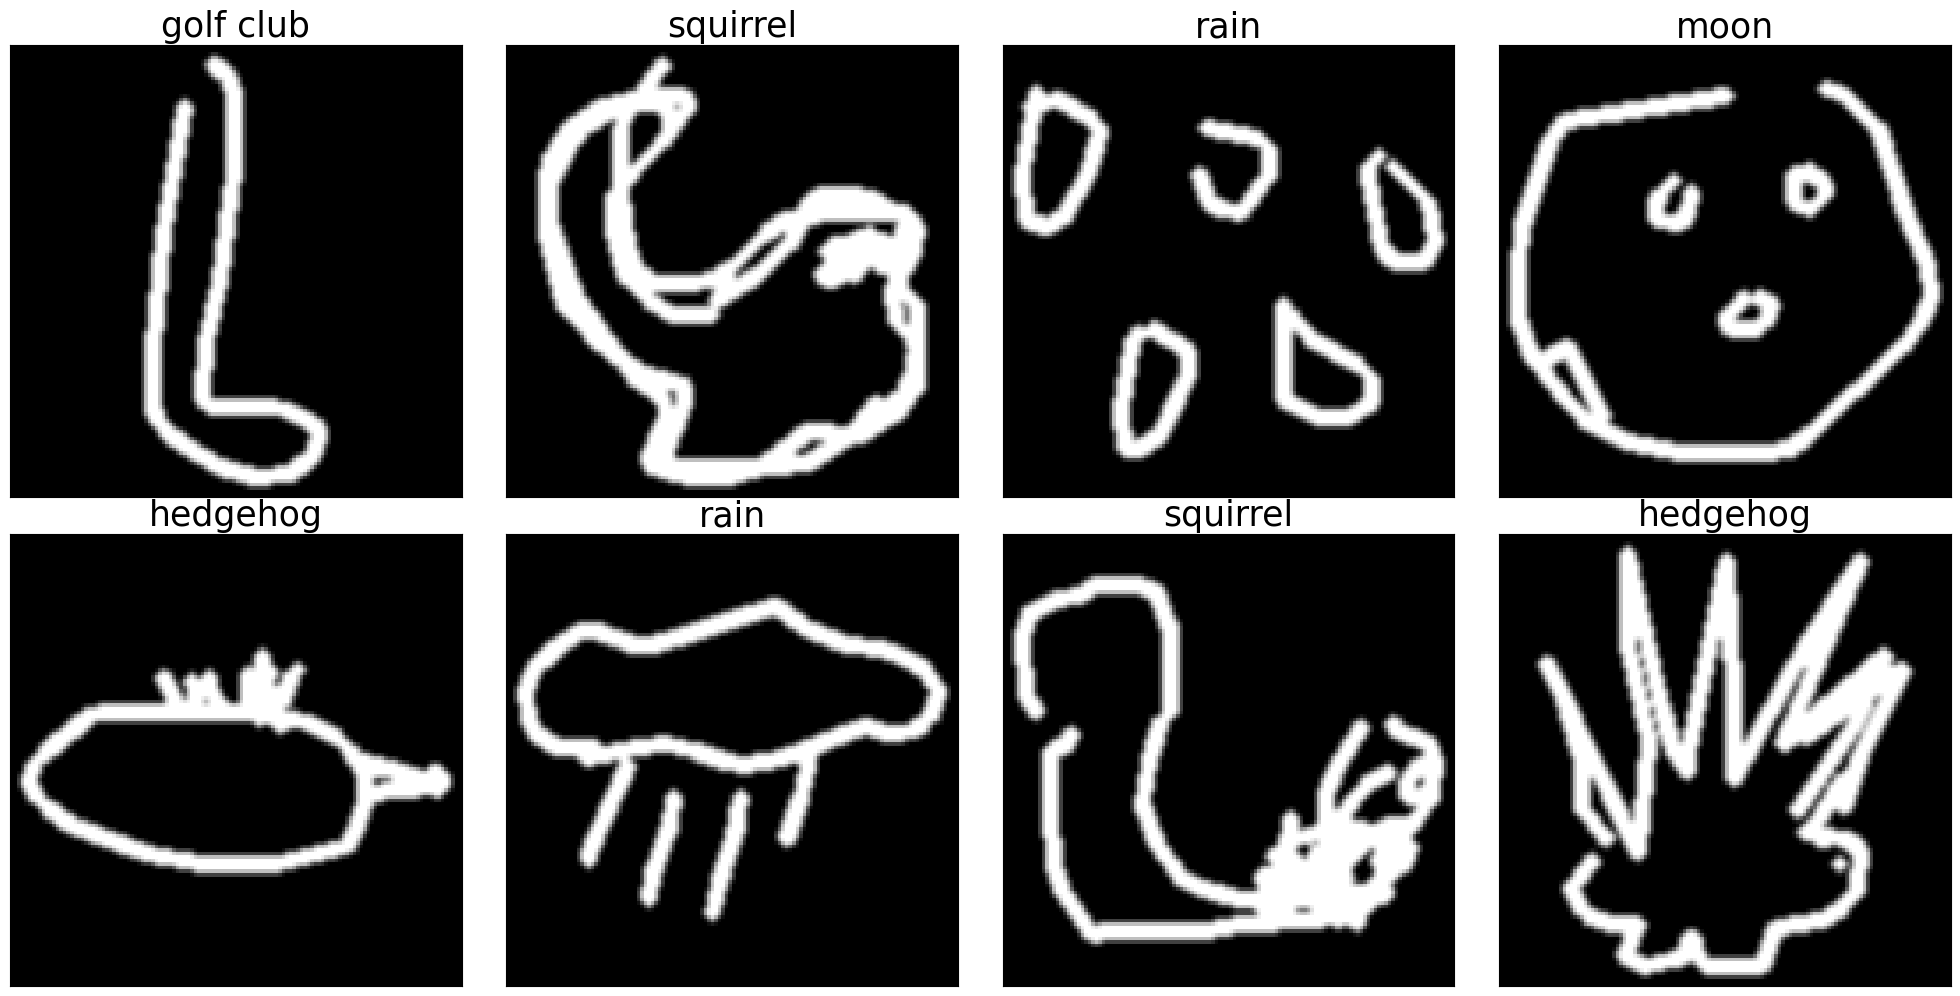

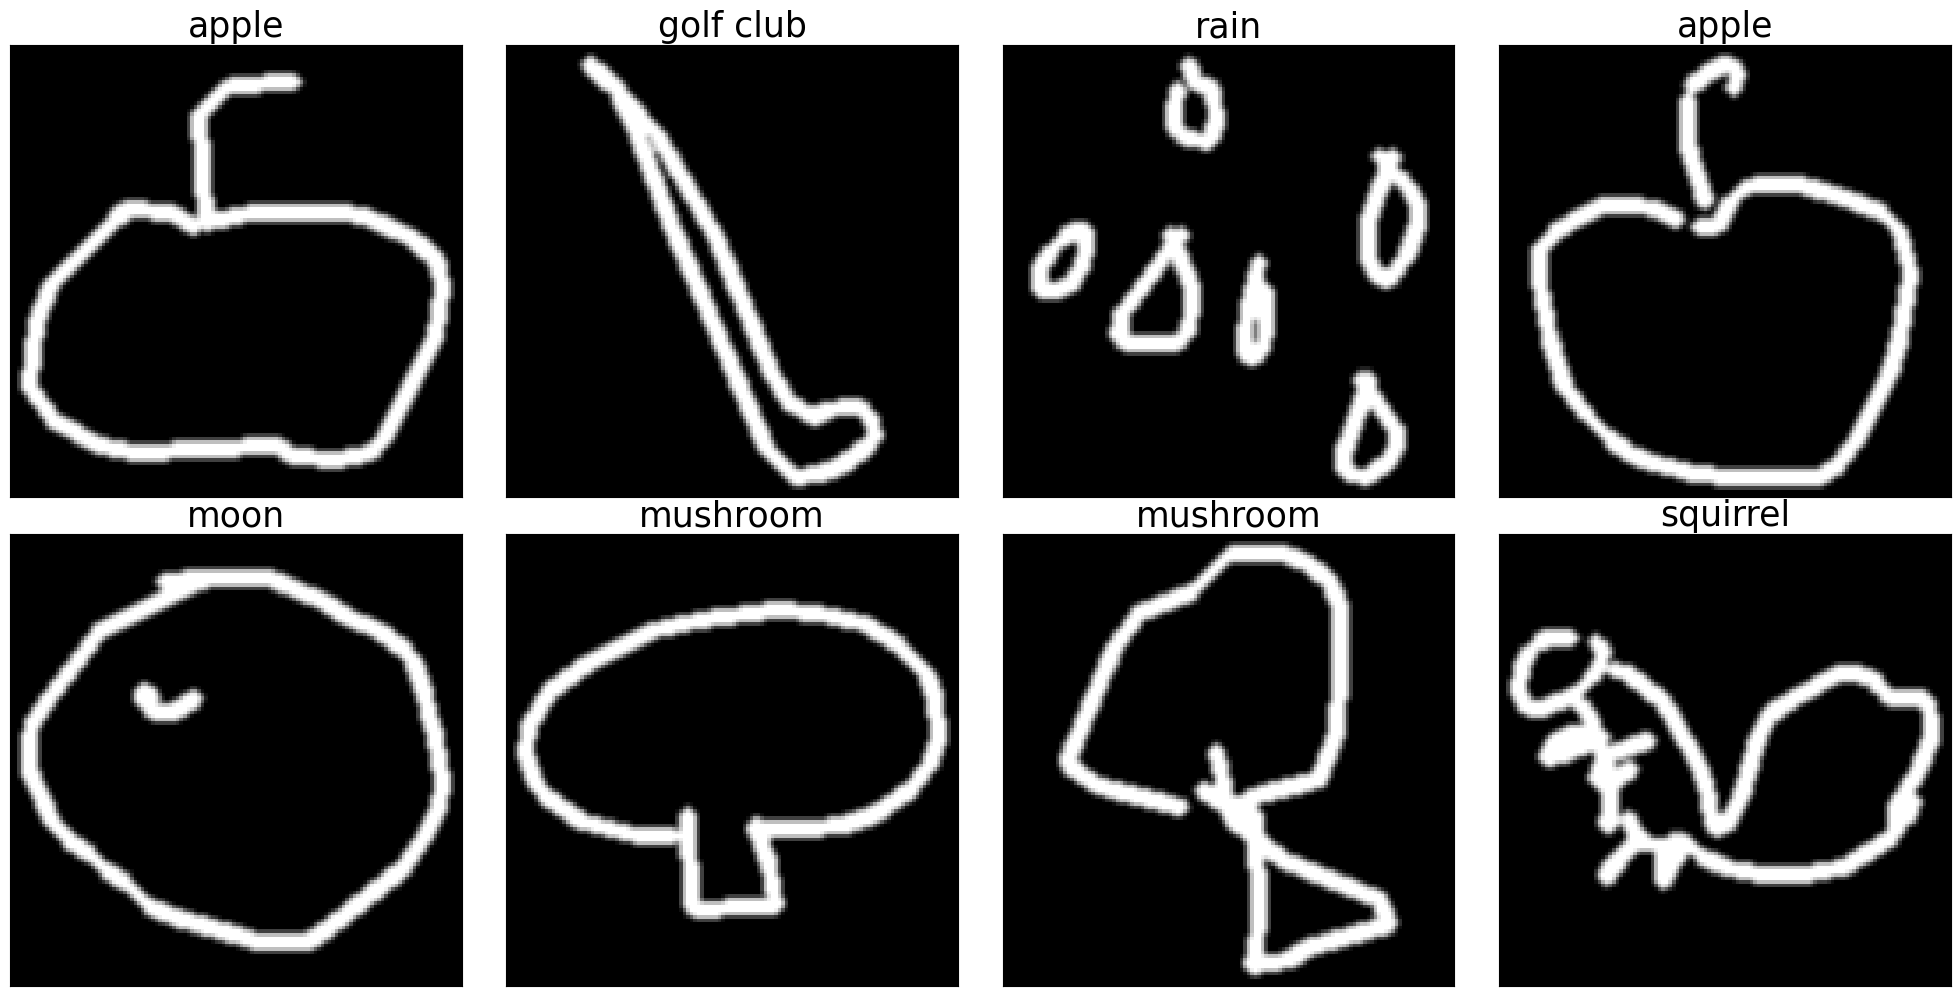

In [10]:
Visualisation.plot_random_images(training_set, classes)

Visualisation.plot_random_images(training_set, classes)

## Autoencoder class

In [11]:
from src.InitModel import InitModel

## Try with a model

In [12]:
autoencoder_model, is_embed_model = InitModel.init_model(
            MODEL,
            device, 
            WIDTH, HEIGHT, classes,  
            CONV_ARCHITECTURE, LINEAR_ARCHITECTURE,  DROPOUT, BATCH_NORM, RL, KL,
            verbose=True)

criterion, optimizer = InitModel.create_criterion_optimizer(MODEL, autoencoder_model, LR)

Chosen model :  <class 'src.conv_VAE_2.ConvVariationalAutoencoder2'>


In [13]:
InitModel.print_model_characteristics(autoencoder_model)

Class :  ConvVariationalAutoencoder2
encoder :
Sequential(
  (encoder_0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_relu_0): ELU(alpha=1.0)
  (encoder_max_pool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_dropout_0): Dropout(p=0.1, inplace=False)
  (encoder_batchnorm_0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
latent space
mu : Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
logvar : Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
latent_exit : Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
decoder :
Sequential(
  (decoder_2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_relu_2): ELU(alpha=1.0)
  (encoder_upsample_2): Upsample(scale_factor=2.0, mode='nearest')
  (encoder_dropout_2): Dropout(p=0.1, inpl

In [14]:
# Check if path exists for weight, else path not and will train

path = os.path.join(PytorchUtils.WEIGHTS_FOLDER, PytorchUtils.give_file_name(autoencoder_model, EPOCHS))

if not os.path.exists(path):
    path = None

autoencoder_model.train_autoencoder(training_loaded_set, validation_loaded_set, optimizer, criterion, EPOCHS, path=path)

Attempting to load weights from : None
Ep [1/57] T L: 50960.5586 T RL: 29275.3496 T KL: 21685.2090 V L: 4709.5200 V RL: 2853.2500 V KL: 1856.2700 T PSNR: 19.2500 T SSIM: 0.2800 V PSNR: 19.2500 V SSIM: 0.2800
Ep [2/57] T L: 35760.0078 T RL: 18548.7461 T KL: 17211.2598 V L: 3446.4000 V RL: 1746.6500 V KL: 1699.7500 T PSNR: 21.6100 T SSIM: 0.4200 V PSNR: 21.6200 V SSIM: 0.4200
Ep [3/57] T L: 33923.6445 T RL: 18302.4863 T KL: 15621.1592 V L: 3243.6900 V RL: 1681.9000 V KL: 1561.7900 T PSNR: 22.1200 T SSIM: 0.5600 V PSNR: 22.1200 V SSIM: 0.5600
Ep [4/57] T L: 31454.2344 T RL: 14780.1650 T KL: 16674.0684 V L: 2993.9700 V RL: 1289.5000 V KL: 1704.4700 T PSNR: 22.9800 T SSIM: 0.6200 V PSNR: 22.9700 V SSIM: 0.6100
Ep [5/57] T L: 29874.6133 T RL: 14419.0527 T KL: 15455.5596 V L: 2739.9200 V RL: 1180.1700 V KL: 1559.7500 T PSNR: 23.0400 T SSIM: 0.6400 V PSNR: 23.0600 V SSIM: 0.6400
Ep [6/57] T L: 29113.6602 T RL: 14695.3721 T KL: 14418.2881 V L: 2580.7800 V RL: 1215.4800 V KL: 1365.3000 T PSNR: 2

KeyboardInterrupt: 

In [ ]:
PytorchUtils.save_checkpoint(autoencoder_model, 25, autoencoder_model.metrics, autoencoder_model.losses, optimizer)

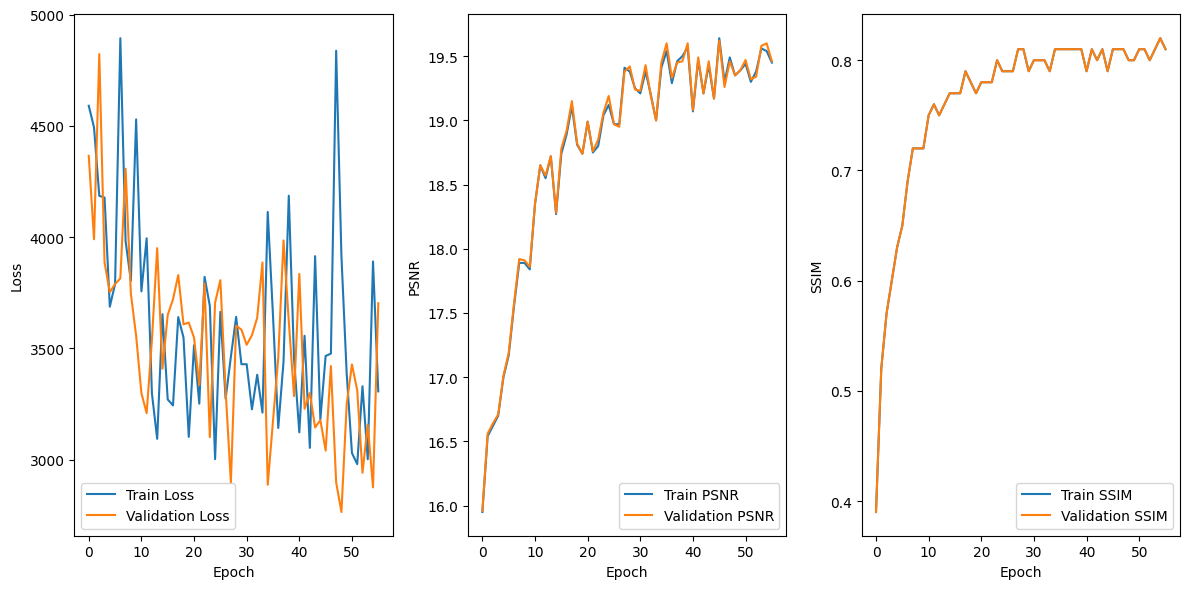

In [ ]:
autoencoder_model.plot_psnr_ssim()

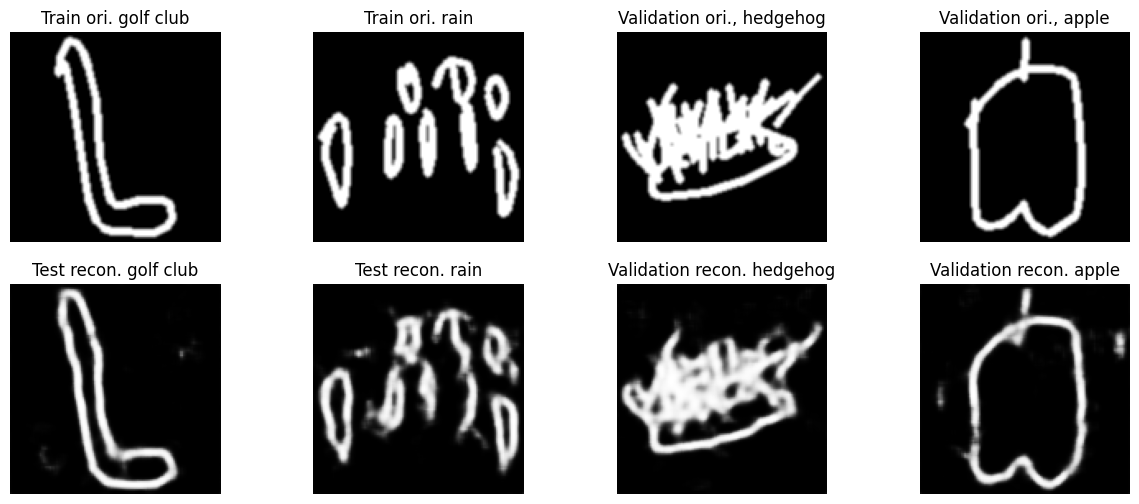

In [ ]:
autoencoder_model.show_images(training_set, test_set)

In [ ]:
CHECK_BACTH_SIZE = 80

training_check_dataloader= DataLoader(training_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)
validation_check_dataloader = DataLoader(validation_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)

In [ ]:
lowest_psnr, lowest_ssim = autoencoder_model.return_lowest_image_index_psnr_ssim(validation_check_dataloader)
print(f'Lowest PSNR index: {lowest_psnr[0]}|{lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]}|{lowest_ssim[1]}')

Lowest PSNR index: 26|13.944914458188308, Lowest SSIM index: 76|0.6488913902090421


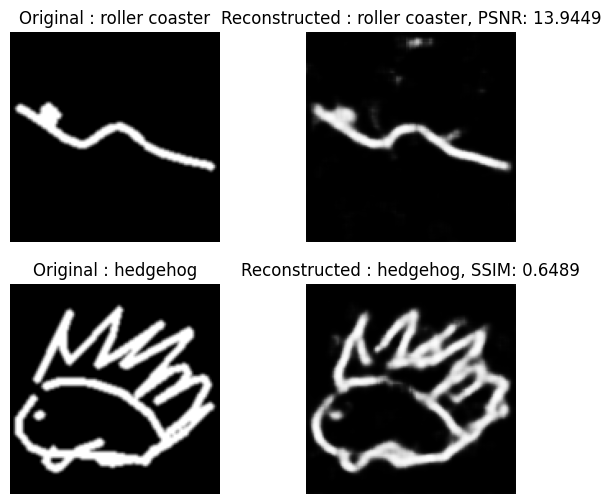

In [ ]:
autoencoder_model.show_lowest_psnr_ssim_image(validation_set, lowest_psnr, lowest_ssim)

# Show latent space

In [ ]:
Visualisation.latent_space_visualization(autoencoder_model, training_loaded_set, use_embedding=True)
Visualisation.latent_space_visualization(autoencoder_model, training_loaded_set, use_embedding=False)

# Generating images

In [ ]:
from src.generator import ImageGenerator

image_generator = ImageGenerator(classes, device, autoencoder_model)

### Generating the mean vectors

Class apple range of mean encoded embed vector: [-4.430437263537293,3.516743137551847]
Class apple range of mean encoded vector: [-4.430437263537293,3.516743137551847]
Class golf club range of mean encoded embed vector: [-4.174567971172103,3.947553565368116]
Class golf club range of mean encoded vector: [-4.174567971172103,3.947553565368116]
Class hedgehog range of mean encoded embed vector: [-3.7270207646275857,3.3245326209114414]
Class hedgehog range of mean encoded vector: [-3.7270207646275857,3.3245326209114414]
Class moon range of mean encoded embed vector: [-3.7258836903359573,4.208998521759326]
Class moon range of mean encoded vector: [-3.7258836903359573,4.208998521759326]
Class mushroom range of mean encoded embed vector: [-3.421645983560668,3.6505871827785787]
Class mushroom range of mean encoded vector: [-3.421645983560668,3.6505871827785787]
Class rain range of mean encoded embed vector: [-3.433592545550959,3.671148611125554]
Class rain range of mean encoded vector: [-3.433

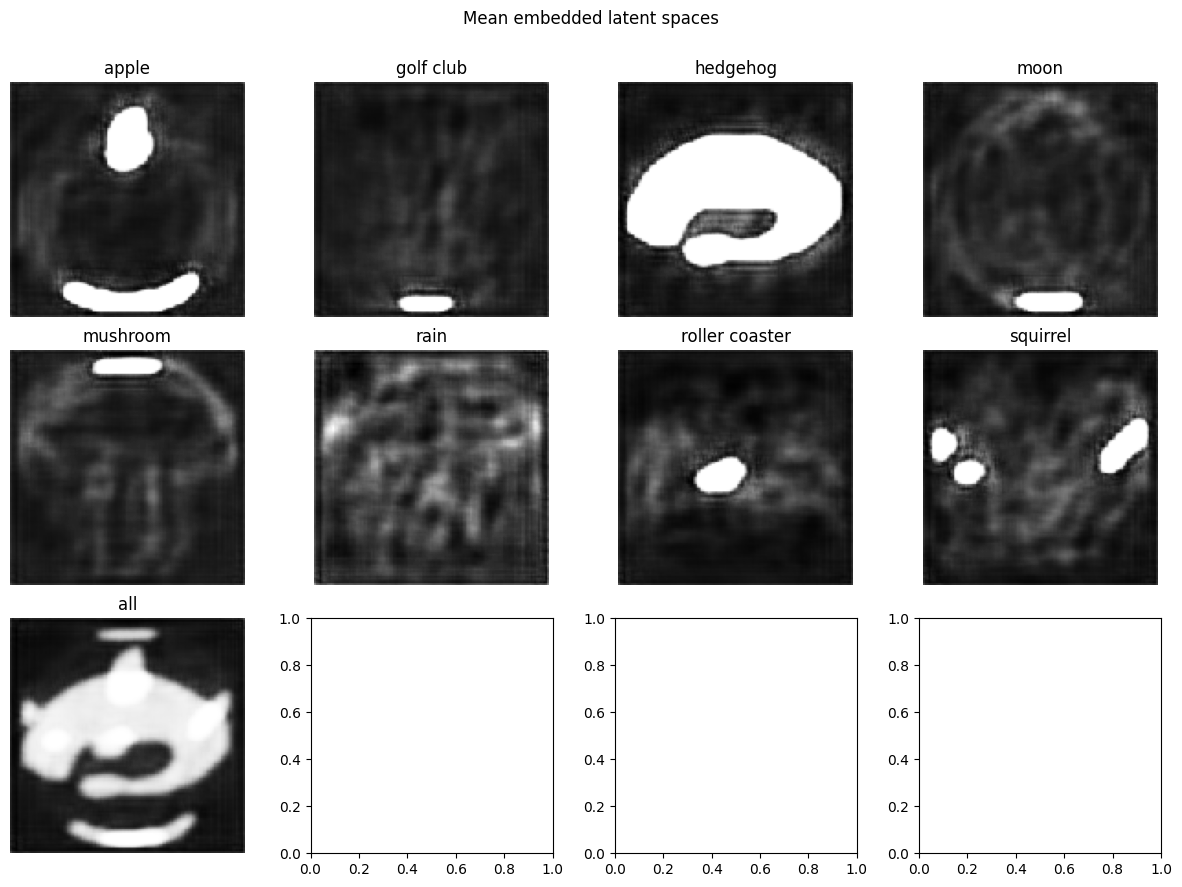

In [ ]:
mean_encoded_information = image_generator.generate_mean_encoded_information(training_loaded_set)

has_embedding = "mean_before" in mean_encoded_information[0].keys()

print(f'has embedding: {has_embedding}')

mean_vectors1 = []
for i in range(len(mean_encoded_information)):
    mean_vectors1.append(mean_encoded_information[i]['mean'])

image_generator.show_generated_images_per_mean_vectors(
        mean_vectors1, 
        title=("Mean embedded latent spaces" if has_embedding else "Mean latent spaces"),
        image_size=(None if autoencoder_model.latent_type == "convolutional" else (WIDTH, HEIGHT)))

### Generating a bit the mean vector by the variance

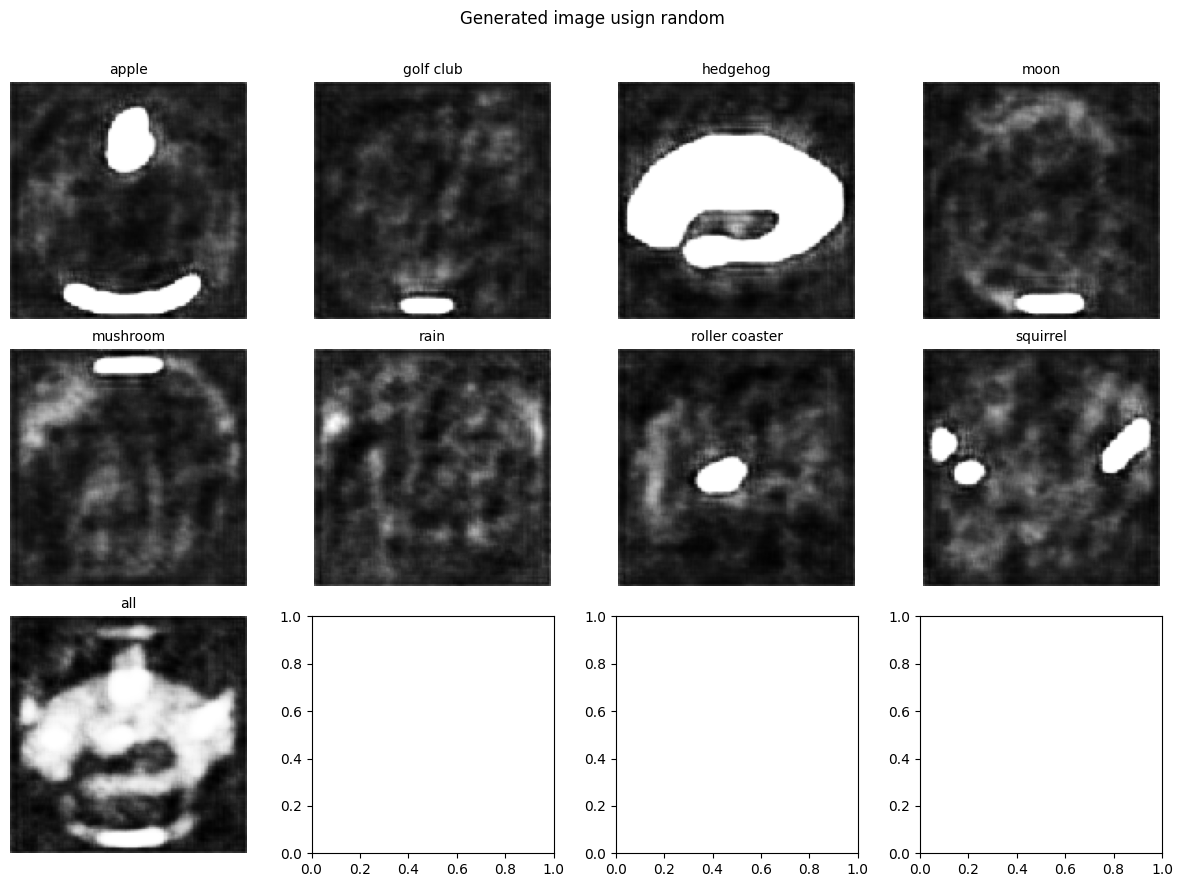

In [ ]:
noised_encoded_vectors = []
titles = []

for i in range(len(mean_encoded_information)):
    alternative = image_generator.create_alternative_version(mean_encoded_information[i]['mean'], 
                                                             mean_encoded_information[i]['var'], 1)

    noised_encoded_vectors.append(alternative)

    if i < len(classes):
        titles.append(classes[i])
    else:
        titles.append("all")
    

image_generator.show_generated_images_per_vector(
    noised_encoded_vectors, 
    titles=titles, 
    title="Generated image usign random", 
    image_size=(None if autoencoder_model.latent_type == "convolutional" else (WIDTH, HEIGHT)))

### Generation of an image to which we add the embeddings of the other classes

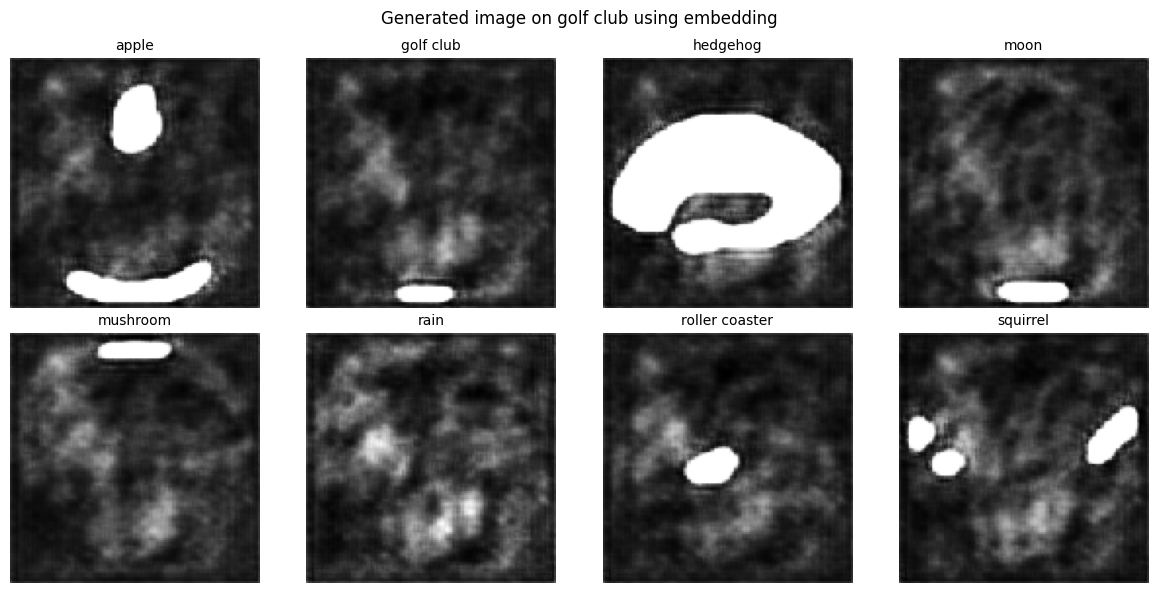

In [ ]:
if is_embed_model:

    image, label = training_set[0]

    latent_spaces = []
    labels = []

    with torch.no_grad():
        image = PytorchUtils.numpy_to_tensor(image, device).unsqueeze(0)
        label = torch.tensor(label).to(device).unsqueeze(0)

        pack = autoencoder_model(image, label)

        encoded_before = PytorchUtils.tensor_to_numpy(pack["encoded_before"])

        for i in range(len(classes)):
            latent_spaces.append(encoded_before)
            labels.append(i)

        image_generator.show_generated_images_per_vector(
            latent_spaces, 
            labels=labels,
            titles=classes, 
            title=f"Generated image on {classes[label]} using embedding", 
            image_size=(None if autoencoder_model.latent_type == "convolutional" else (WIDTH, HEIGHT)))

# Interpolation

### z_embed class (n) => z_embed' class (n)

In [ ]:
def add(tuple, a, b, c):
    a += tuple[0]
    b += tuple[1]
    c += tuple[2]

from utils.DatasetUtils import DatasetUtils

n_images = 3
interpolation = 8

label_1 = 0
label_2 = 1
label_3 = 2

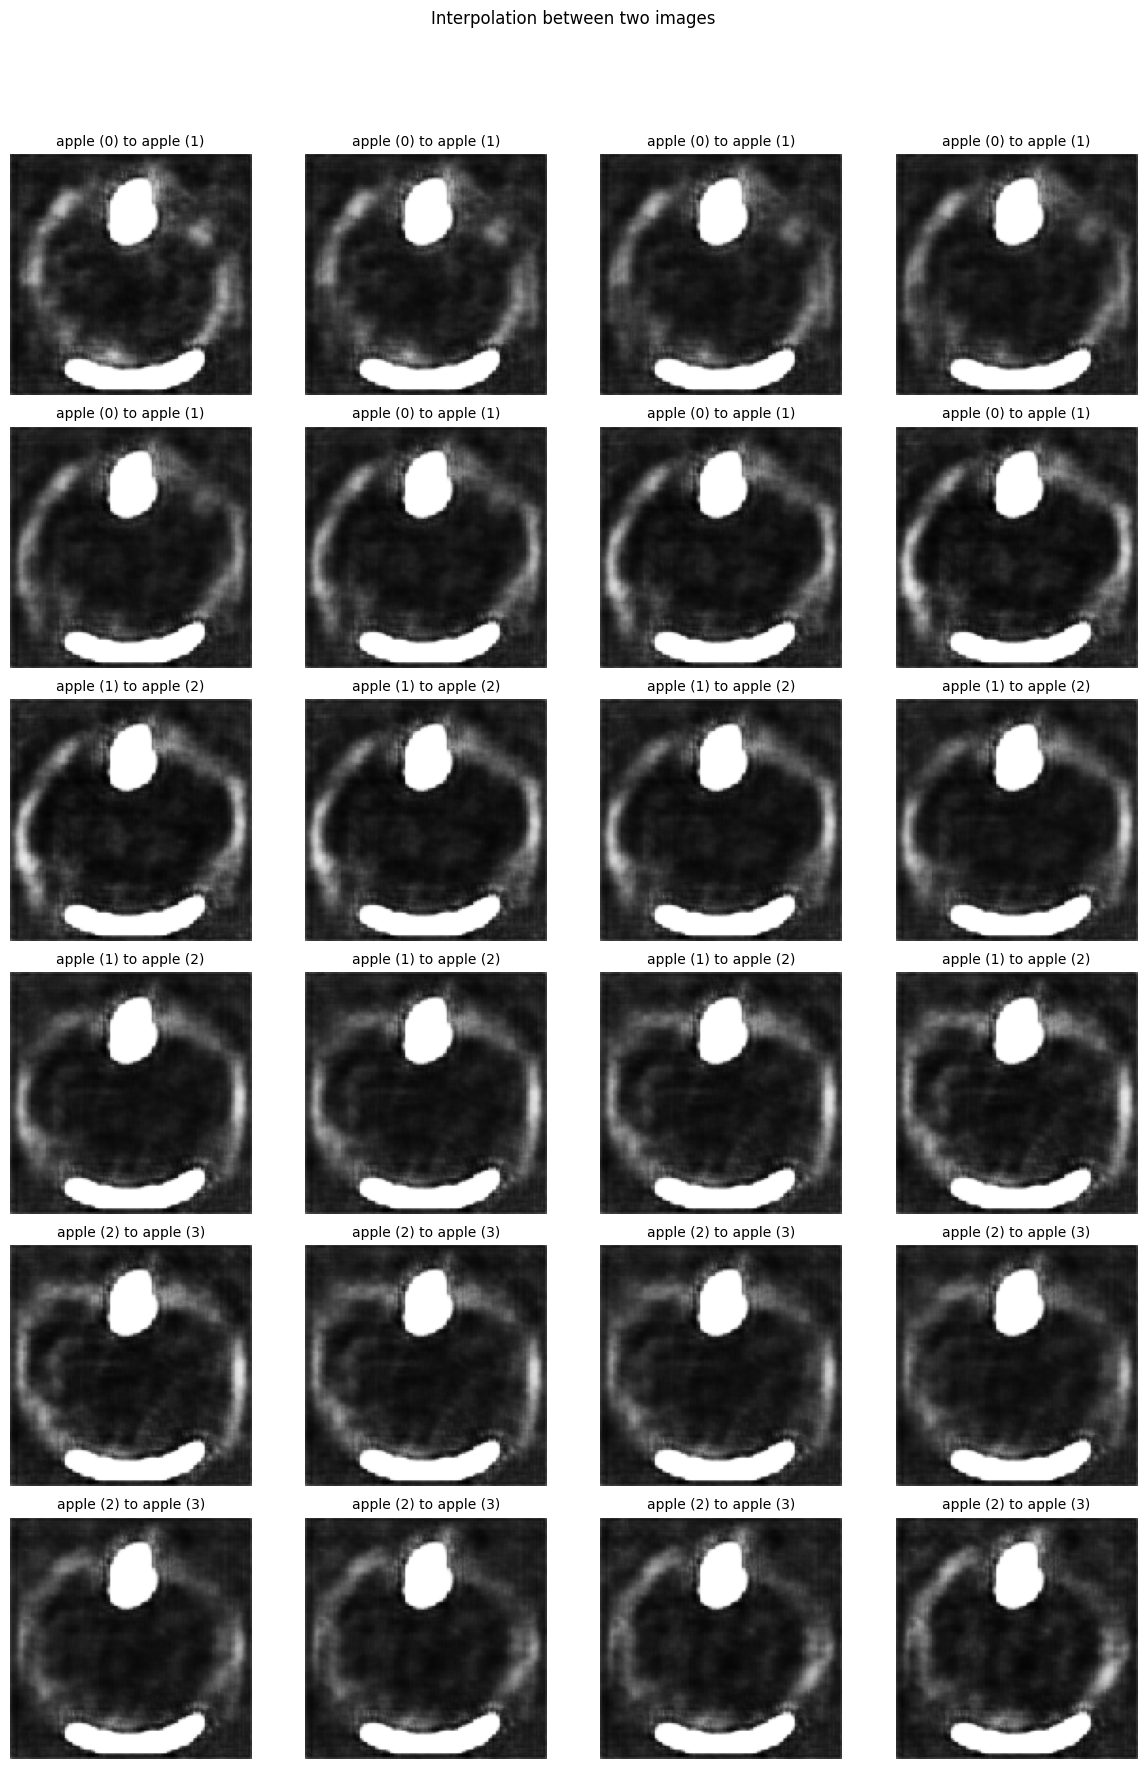

In [ ]:
images, image_labels, image_indices = DatasetUtils.get_n_first_for_label(training_set, label_1, n_images)
images.append(images[0])
image_labels.append(image_labels[0])
image_indices.append(image_indices[0])

encoded = []
titles = []

with torch.no_grad():
    for i in range(len(images)):
        if i < len(images) - 1:
            for j in range(interpolation):
                titles.append(f"{classes[image_labels[i]]} ({i}) to {classes[image_labels[i + 1]]} ({i + 1})")


        pack = autoencoder_model(PytorchUtils.numpy_to_tensor(images[i], device).unsqueeze(0), torch.tensor(image_labels[i]).to(device).unsqueeze(0))
        encoded.append(pack['encoded'])

    images = image_generator.interpolate_vectors(encoded, 
                                                interpolation_number=interpolation, 
                                                save_path="results/embed_n_to_n/", 
                                                image_size=(None if autoencoder_model.latent_type == "convolutional" else (WIDTH, HEIGHT)))

    image_generator.show_generated_images(images, 
                                        title="Interpolation between two images",
                                        titles=titles)

### z_embed class (n) => z_embed' class (m, n != m)

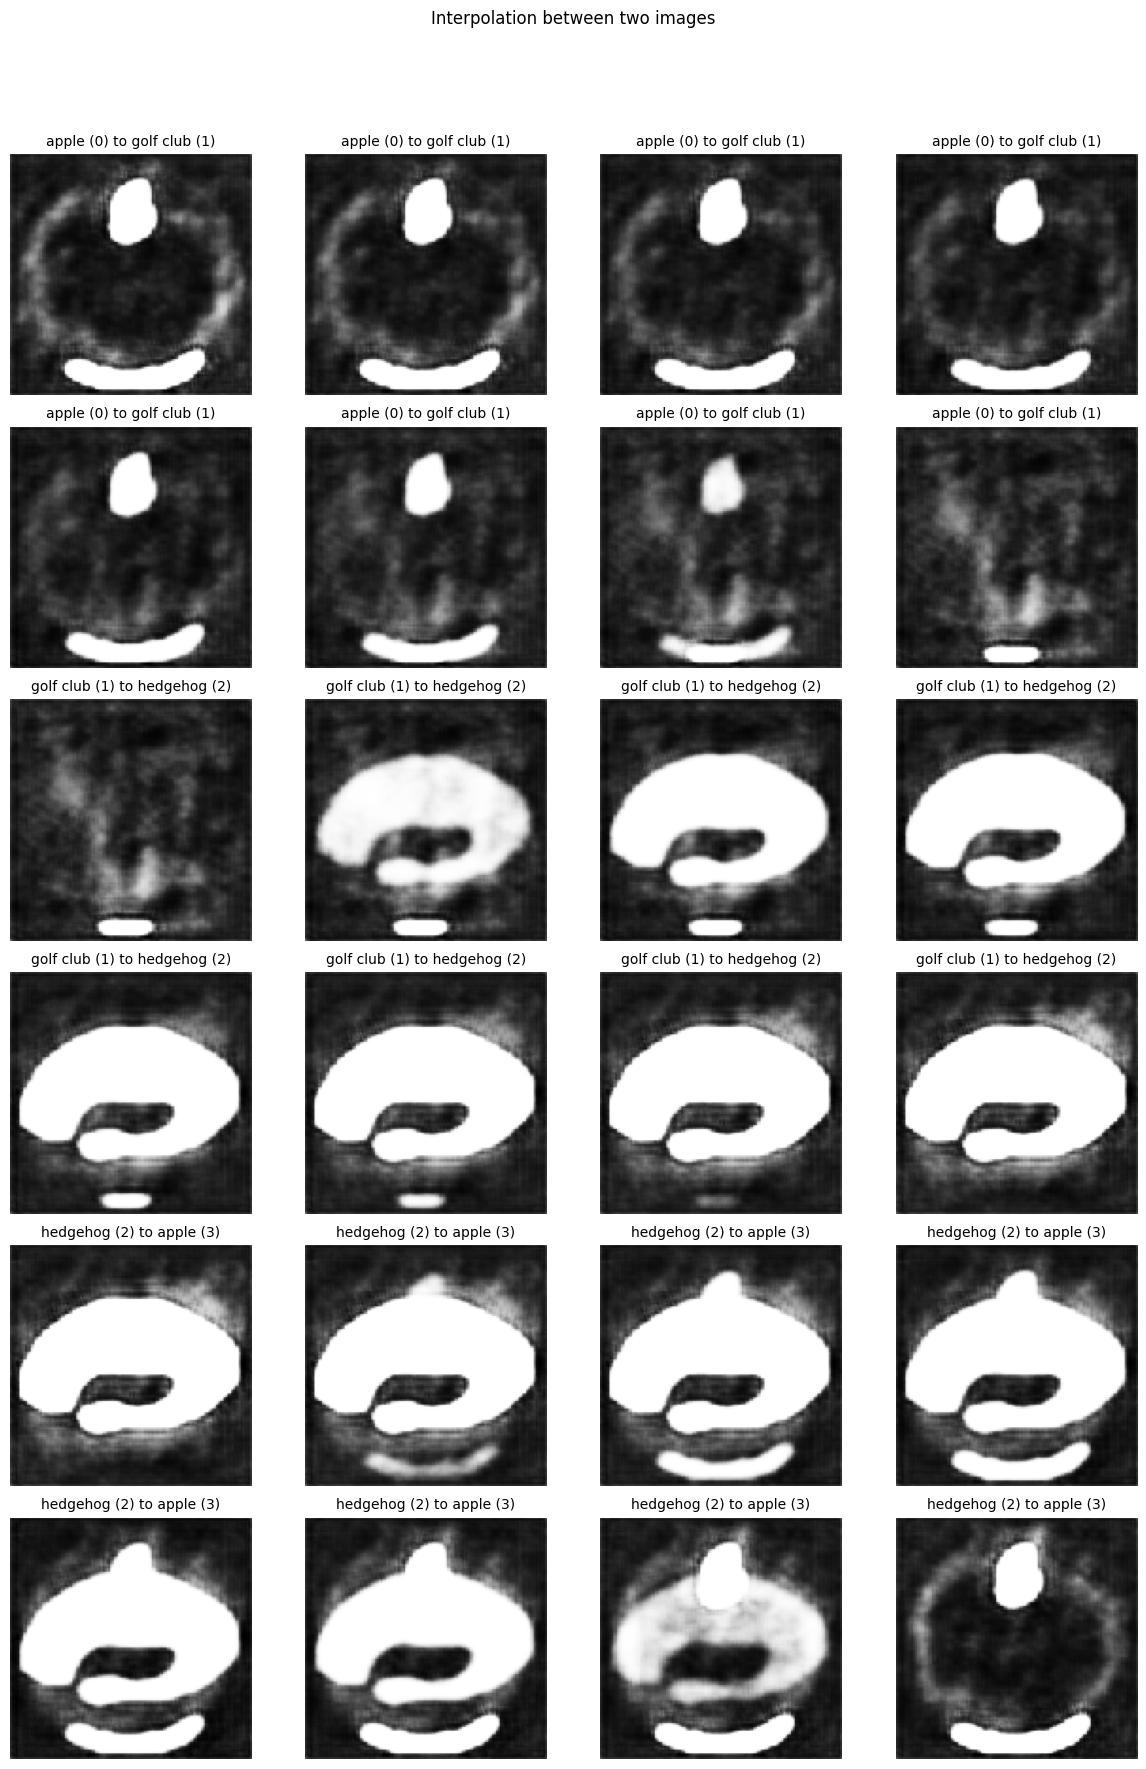

In [ ]:
images, image_labels, image_indices = [], [], []

add(DatasetUtils.get_n_first_for_label(training_set, label_1, 1), images, image_labels, image_indices)
add(DatasetUtils.get_n_first_for_label(training_set, label_2, 1), images, image_labels, image_indices)
add(DatasetUtils.get_n_first_for_label(training_set, label_3, 1), images, image_labels, image_indices)

images.append(images[0])
image_labels.append(image_labels[0])
image_indices.append(image_indices[0])

encoded = []
titles = []

with torch.no_grad():
    for i in range(len(images)):
        if i < len(images) - 1:
            for j in range(interpolation):
                titles.append(f"{classes[image_labels[i]]} ({i}) to {classes[image_labels[i + 1]]} ({i + 1})")


        pack = autoencoder_model(PytorchUtils.numpy_to_tensor(images[i], device).unsqueeze(0), torch.tensor(image_labels[i]).to(device).unsqueeze(0))
        encoded.append(pack['encoded'])

    images = image_generator.interpolate_vectors(encoded, 
                                                interpolation_number=interpolation, 
                                                save_path="results/embed_n_to_m/", 
                                                image_size=(None if autoencoder_model.latent_type == "convolutional" else (WIDTH, HEIGHT)))

    image_generator.show_generated_images(images, 
                                        title="Interpolation between two images",
                                        titles=titles)

### z (class n) + embed_class m => z' (class m, n != m) + embed_class n

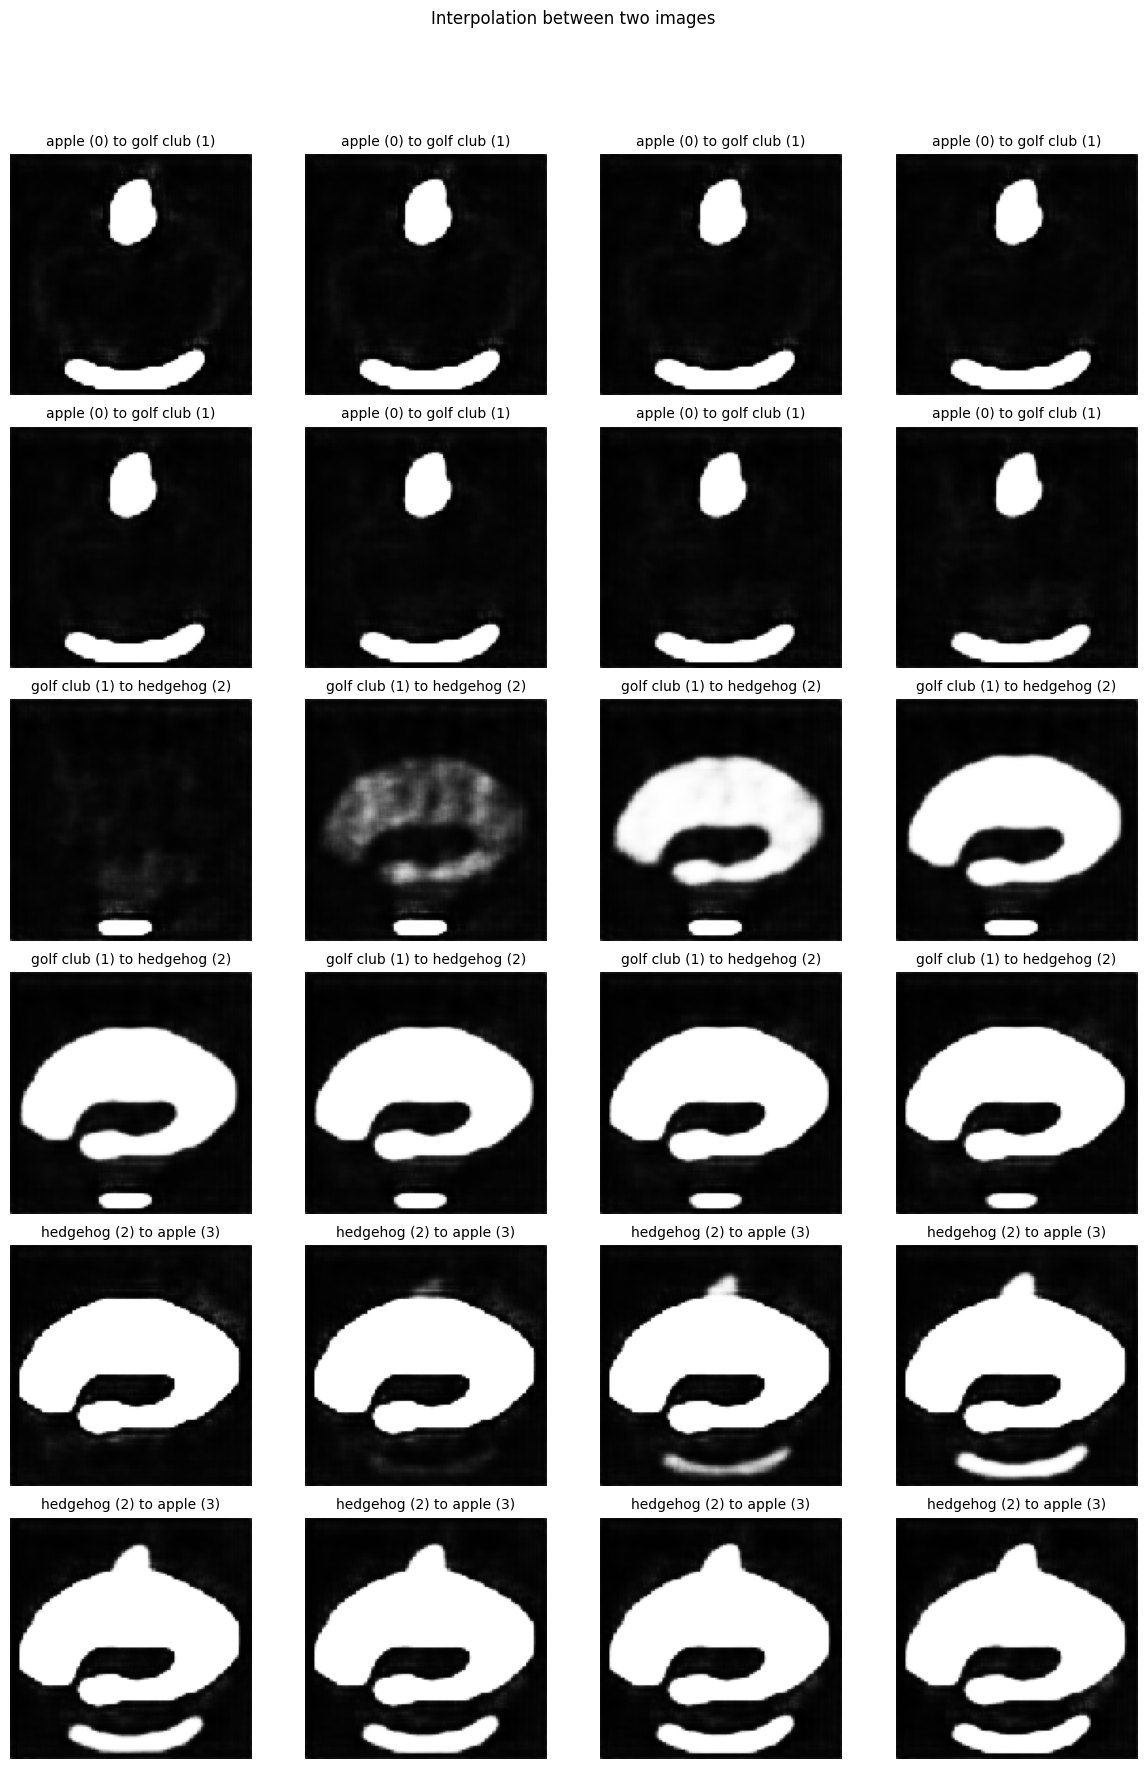

In [ ]:
if is_embed_model:
    images, image_labels, image_indices = [], [], []

    add(DatasetUtils.get_n_first_for_label(training_set, label_1, 1), images, image_labels, image_indices)
    add(DatasetUtils.get_n_first_for_label(training_set, label_2, 1), images, image_labels, image_indices)
    add(DatasetUtils.get_n_first_for_label(training_set, label_3, 1), images, image_labels, image_indices)

    images.append(images[0])
    image_labels.append(image_labels[0])
    image_indices.append(image_indices[0])

    encoded = []
    titles = []

    with torch.no_grad():
        for i in range(len(images)):
            if i < len(images) - 1:
                for j in range(interpolation):
                    titles.append(f"{classes[image_labels[i]]} ({i}) to {classes[image_labels[i + 1]]} ({i + 1})")

            pack = autoencoder_model(PytorchUtils.numpy_to_tensor(images[i], device).unsqueeze(0), torch.tensor(image_labels[i]).to(device).unsqueeze(0))
            encoded.append(pack['encoded'])

        images = image_generator.interpolate_vectors(encoded, 
                                                    interpolation_number=interpolation, 
                                                    save_path="results/n_to_m_embed_before/", 
                                                    image_size=(None if autoencoder_model.latent_type == "convolutional" else (WIDTH, HEIGHT)),
                                                    labels=image_labels)

        image_generator.show_generated_images(images, 
                                            title="Interpolation between two images",
                                            titles=titles)

### z (class n) + embed_class m => z' (class m, n != m) + embed_class m

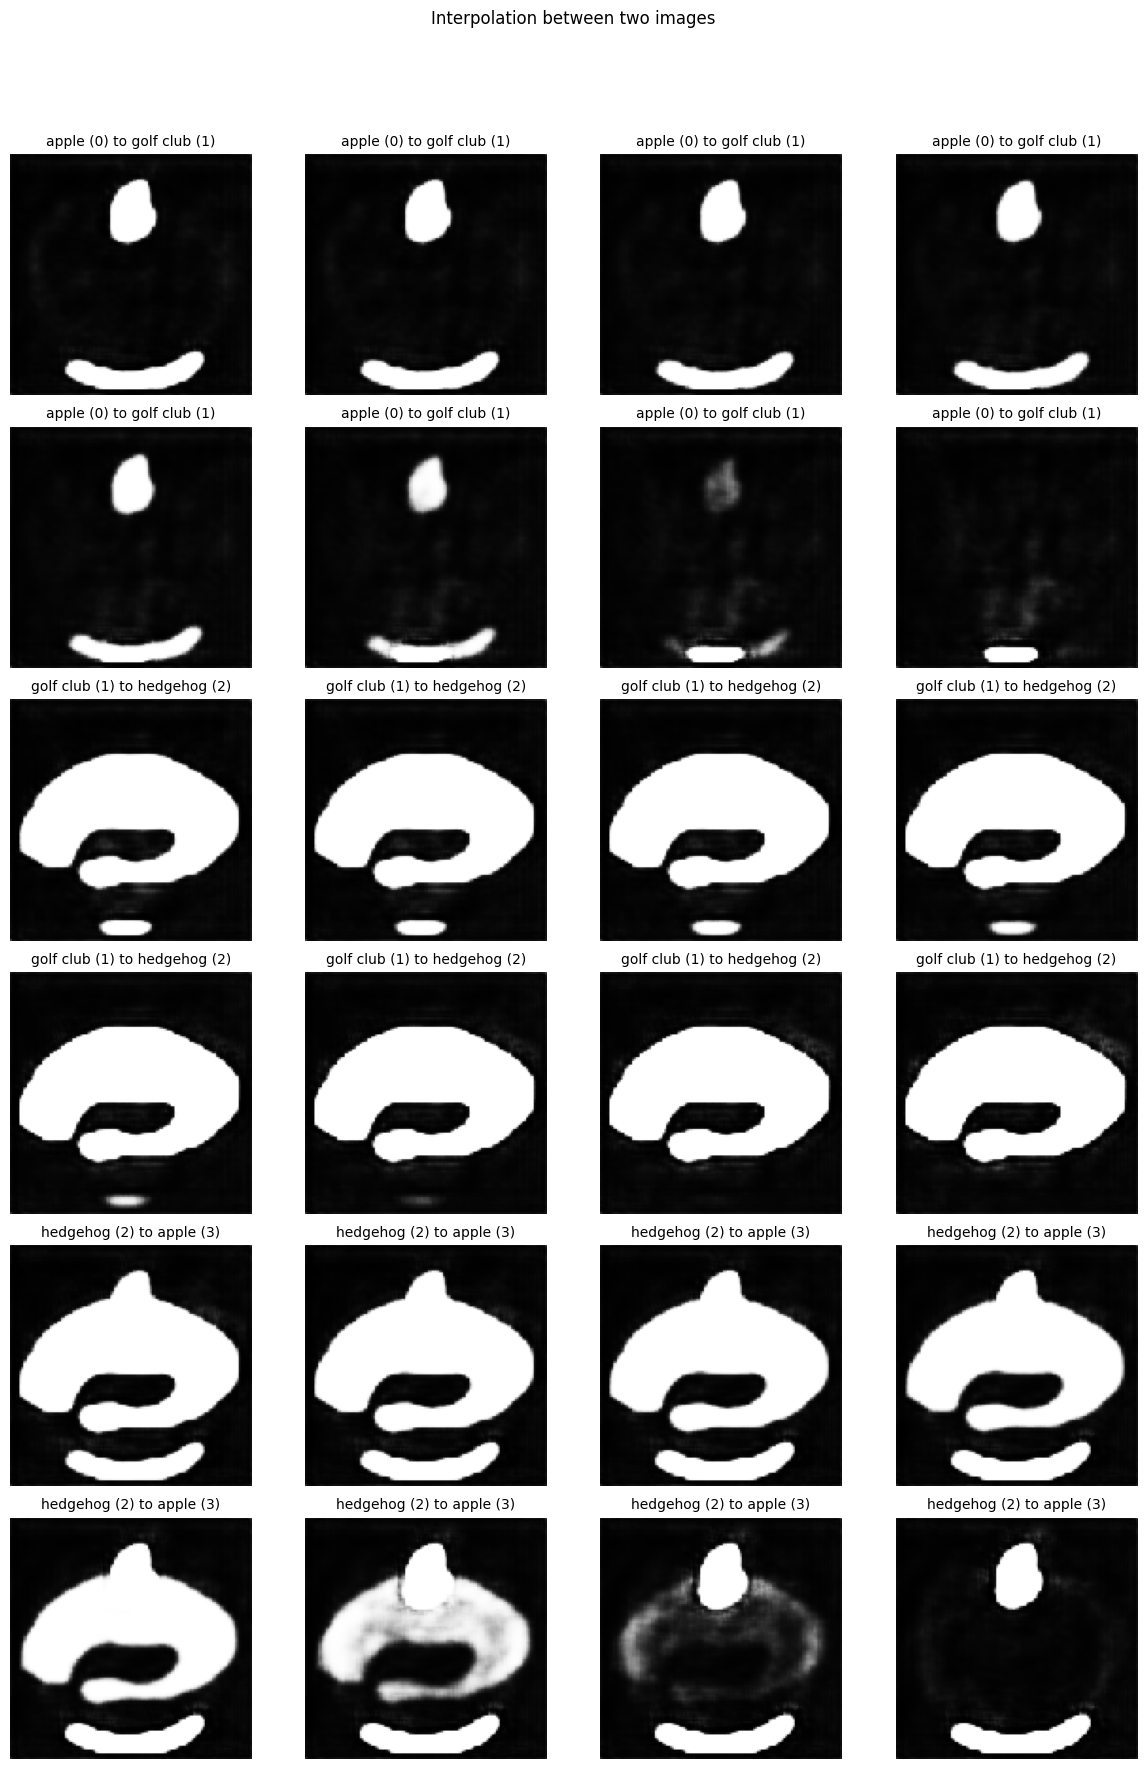

In [ ]:
if is_embed_model:

    images, image_labels, image_indices = [], [], []

    add(DatasetUtils.get_n_first_for_label(training_set, label_1, 1), images, image_labels, image_indices)
    add(DatasetUtils.get_n_first_for_label(training_set, label_2, 1), images, image_labels, image_indices)
    add(DatasetUtils.get_n_first_for_label(training_set, label_3, 1), images, image_labels, image_indices)

    images.append(images[0])
    image_labels.append(image_labels[0])
    image_indices.append(image_indices[0])

    encoded = []
    titles = []

    with torch.no_grad():
        for i in range(len(images)):
            if i < len(images) - 1:
                for j in range(interpolation):
                    titles.append(f"{classes[image_labels[i]]} ({i}) to {classes[image_labels[i + 1]]} ({i + 1})")

            pack = autoencoder_model(PytorchUtils.numpy_to_tensor(images[i], device).unsqueeze(0), torch.tensor(image_labels[i]).to(device).unsqueeze(0))
            encoded.append(pack['encoded'])

        # move labels by one
        del image_labels[0]

        images = image_generator.interpolate_vectors(encoded, 
                                                    interpolation_number=interpolation, 
                                                    save_path="results/n_to_m_embed_after/", 
                                                    image_size=(None if autoencoder_model.latent_type == "convolutional" else (WIDTH, HEIGHT)),
                                                    labels=image_labels)

        image_generator.show_generated_images(images, 
                                            title="Interpolation between two images",
                                            titles=titles)

### z (class n) + embed_class m => z' (class m) + embed_class n, n !=m

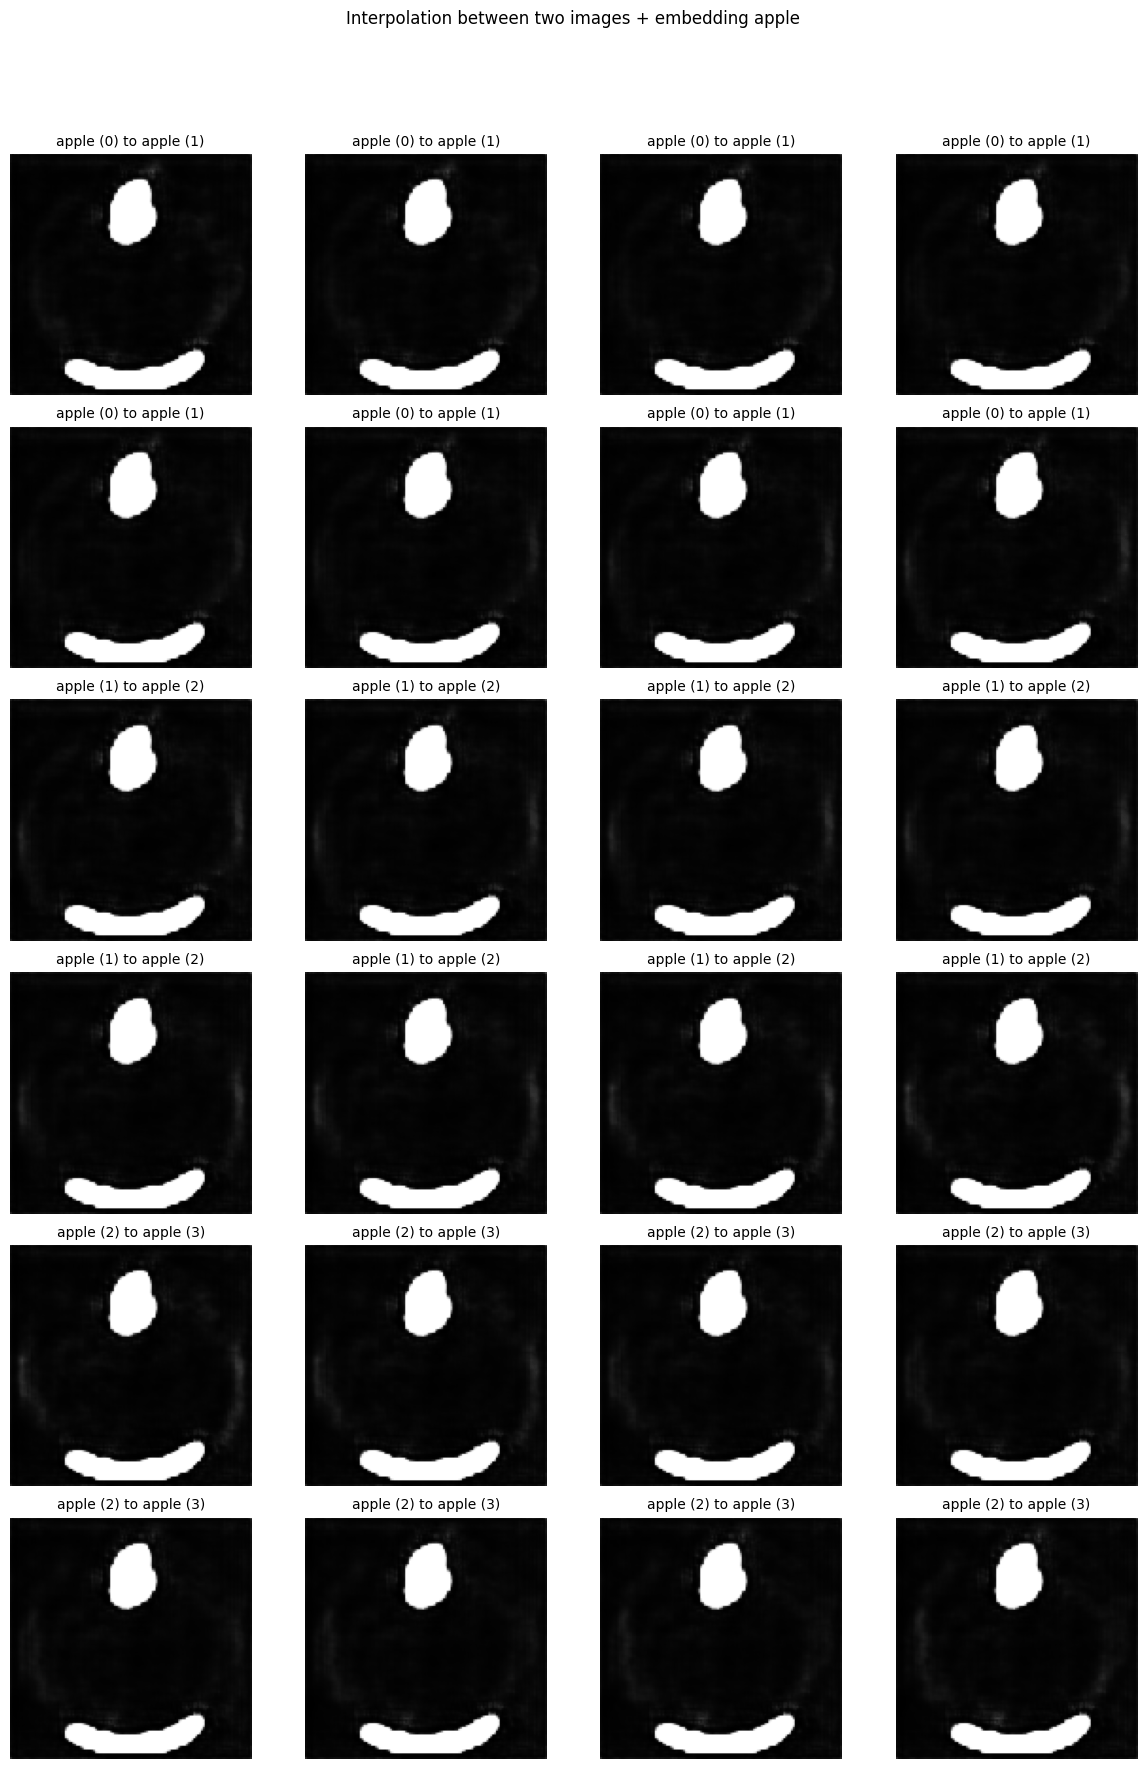

In [ ]:
if is_embed_model:

    images, image_labels, image_indices = DatasetUtils.get_n_first_for_label(training_set, label_1, n_images)

    # take randomly another label without being the same as label_1
    other_label = random.randint(0, nb_classes - 1)
    other_labels = []

    images.append(images[0])
    image_labels.append(image_labels[0])
    image_indices.append(image_indices[0])

    encoded = []
    titles = []

    with torch.no_grad():
        for i in range(len(images)):
            if i < len(images) - 1:
                for j in range(interpolation):
                    titles.append(f"{classes[image_labels[i]]} ({i}) to {classes[image_labels[i + 1]]} ({i + 1})")

            pack = autoencoder_model(PytorchUtils.numpy_to_tensor(images[i], device).unsqueeze(0), torch.tensor(image_labels[i]).to(device).unsqueeze(0))
            encoded.append(pack['encoded'])

            other_labels.append(other_label)


        images = image_generator.interpolate_vectors(encoded, 
                                                    interpolation_number=interpolation, 
                                                    save_path="results/n_to_m_embed_other/", 
                                                    image_size=(None if autoencoder_model.latent_type == "convolutional" else (WIDTH, HEIGHT)),
                                                    labels=other_labels)

        image_generator.show_generated_images(images, 
                                            title="Interpolation between two images + embedding " + str(classes[other_label]),
                                            titles=titles)